# Hospital Utilization Analysis: Diagnoses Driving Costs & Stays  
*Exploratory Data Analysis of 2012 NY Inpatient Discharges*  

### **Project Overview**  
This notebook analyzes **hospitalization costs** and **length of stay (LOS)** patterns across diagnoses in New York State (2012 SPARCS data), focusing on:
1. **Cost drivers**
2. **LOS Outliers**
3. **Severity Impact**

### **Key Questions**  
- Which diagnoses contribute most to costs/LOS variability?  
- How does severity level correlate with outcomes?  
- Are there benchmarks for efficient care? 

In [2]:
# import libraries
# data manipulation 
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

In [3]:
# Loading the data
df = pd.read_csv("../data/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012_20250408.csv", low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544543 entries, 0 to 2544542
Data columns (total 34 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Health Service Area                  object 
 1   Hospital County                      object 
 2   Operating Certificate Number         float64
 3   Facility ID                          float64
 4   Facility Name                        object 
 5   Age Group                            object 
 6   Zip Code - 3 digits                  object 
 7   Gender                               object 
 8   Race                                 object 
 9   Ethnicity                            object 
 10  Length of Stay                       object 
 11  Type of Admission                    object 
 12  Patient Disposition                  object 
 13  Discharge Year                       int64  
 14  CCS Diagnosis Code                   int64  
 15  CCS Diagnosis Description       

In [5]:
# Inspect dataset dimensions
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataset has 2544543 rows and 34 columns.


In [6]:
# Inspect a random sample 
df.sample(10)

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
750662,Hudson Valley,Orange,3522000.0,694.0,St Luke's Cornwall Hospital/Newburgh,70 or Older,125,M,White,Not Span/Hispanic,...,Moderate,Medical,Federal/State/Local/VA,NaN,NaN,0,N,Y,11163.70,2127.54
125419,Western NY,Erie,1404000.0,267.0,Kenmore Mercy Hospital,70 or Older,140,M,White,Not Span/Hispanic,...,Major,Surgical,Medicare,Medicare,Blue Cross/Blue Shield,0,N,N,27189.25,12045.32
1504902,New York City,Manhattan,7002002.0,1439.0,Beth Israel Medical Center/Petrie Campus,50 to 69,100,M,Black/African American,Spanish/Hispanic,...,Minor,Medical,Medicare,Miscellaneous/Other,Self-Pay,0,N,Y,9924.80,2447.92
2538971,Long Island,Suffolk,5157003.0,943.0,St Catherine of Siena Hospital,50 to 69,113,M,White,Not Span/Hispanic,...,Minor,Surgical,Blue Cross/Blue Shield,Private Health Insurance,NaN,0,N,N,27077.73,6832.62
278494,Finger Lakes,Monroe,2701005.0,413.0,Strong Memorial Hospital,18 to 29,145,M,Black/African American,Not Span/Hispanic,...,Minor,Medical,Medicaid,Medicaid,NaN,0,N,Y,11705.33,8059.97
1789944,New York City,Manhattan,7002054.0,1464.0,New York Presbyterian Hospital - Columbia Pres...,0 to 17,109,F,White,Not Span/Hispanic,...,Minor,Medical,Blue Cross/Blue Shield,Self-Pay,NaN,3500,N,N,4224.26,278.04
873835,Hudson Valley,Westchester,5902002.0,1046.0,Winifred Masterson Burke Rehabilitation Hospital,50 to 69,105,M,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,N,14094.21,7064.96
494210,Central NY,Onondaga,3301008.0,636.0,Crouse Hospital,18 to 29,131,F,Other Race,Not Span/Hispanic,...,Minor,Medical,Medicaid,Medicaid,NaN,0,N,N,8175.65,3777.20
1221557,New York City,Kings,7001009.0,1294.0,Coney Island Hospital,30 to 49,112,M,Other Race,Not Span/Hispanic,...,Minor,Medical,Medicaid,Medicaid,NaN,0,N,Y,11561.82,14777.81
2017117,New York City,Queens,7003007.0,1633.0,Queens Hospital Center,18 to 29,114,F,Black/African American,Not Span/Hispanic,...,Minor,Medical,Medicaid,Medicaid,NaN,0,N,Y,4725.13,3981.89


In [7]:
# Standardize the column names 
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

print(df.columns)

Index(['health_service_area', 'hospital_county',
       'operating_certificate_number', 'facility_id', 'facility_name',
       'age_group', 'zip_code___3_digits', 'gender', 'race', 'ethnicity',
       'length_of_stay', 'type_of_admission', 'patient_disposition',
       'discharge_year', 'ccs_diagnosis_code', 'ccs_diagnosis_description',
       'ccs_procedure_code', 'ccs_procedure_description', 'apr_drg_code',
       'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description',
       'apr_severity_of_illness_code', 'apr_severity_of_illness_description',
       'apr_risk_of_mortality', 'apr_medical_surgical_description',
       'payment_typology_1', 'payment_typology_2', 'payment_typology_3',
       'birth_weight', 'abortion_edit_indicator',
       'emergency_department_indicator', 'total_charges', 'total_costs'],
      dtype='object')


In [8]:
# Missing values analysis 
print(f"\nMissing Values Report ({len(df):,} total records)")

# Calculate missing stats
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

# Create display report 
missing_report = (
    pd.DataFrame({
        "missing_count": missing_counts,
        "missing_percentage": missing_pct.round(1)
    })
    .query("missing_count > 0")
    .sort_values("missing_percentage", ascending=False)
)

if not missing_report.empty:
    display(
        missing_report.style
        .background_gradient(cmap="Reds", subset=["missing_percentage"])
        .format({"missing_percentage": "{:.1f}%"})
    )
    print(f"\nTotal Missing Values: {missing_counts.sum():,} ({missing_pct.mean():.1f}% of all data)")
else:
    print("No missing values found in any columns")



Missing Values Report (2,544,543 total records)


,missing_count,missing_percentage
payment_typology_3,1824441,71.7%
payment_typology_2,763177,30.0%
zip_code___3_digits,38670,1.5%
health_service_area,6788,0.3%
hospital_county,6788,0.3%
facility_id,6788,0.3%
operating_certificate_number,6788,0.3%
apr_risk_of_mortality,89,0.0%
apr_severity_of_illness_description,89,0.0%



Total Missing Values: 2,653,618 (3.1% of all data)


In [9]:
# Subset data to explore selected features
selected_features = [
    "health_service_area", "age_group", "gender",
    "race", "ethnicity", "length_of_stay", "type_of_admission",
    "patient_disposition", "discharge_year", "ccs_diagnosis_code",
    "ccs_diagnosis_description", "apr_severity_of_illness_code",
    "apr_severity_of_illness_description", "total_costs"
    ]

In [10]:
# New selected features dataframe 
subset_df = df[selected_features].copy()

subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544543 entries, 0 to 2544542
Data columns (total 14 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   health_service_area                  object 
 1   age_group                            object 
 2   gender                               object 
 3   race                                 object 
 4   ethnicity                            object 
 5   length_of_stay                       object 
 6   type_of_admission                    object 
 7   patient_disposition                  object 
 8   discharge_year                       int64  
 9   ccs_diagnosis_code                   int64  
 10  ccs_diagnosis_description            object 
 11  apr_severity_of_illness_code         int64  
 12  apr_severity_of_illness_description  object 
 13  total_costs                          float64
dtypes: float64(1), int64(3), object(10)
memory usage: 271.8+ MB


In [11]:
# Subset missing values analysis 
print(f"\nSubset Missing Values Report ({len(subset_df):,} total subset records)")

# Calculate missing stats
subset_missing_counts = subset_df.isnull().sum()
subset_missing_pct = (subset_missing_counts / len(subset_df)) * 100

# Create display subset report 
subset_missing_report = (
    pd.DataFrame({
        "subset_missing_count": subset_missing_counts,
        "subset_missing_percentage": subset_missing_pct.round(1)
    })
    .query("subset_missing_count > 0")
    .sort_values("subset_missing_percentage", ascending=False)
)

if not subset_missing_report.empty:
    display(
        subset_missing_report.style
        .background_gradient(cmap="Reds", subset=["subset_missing_percentage"])
        .format({"subset_missing_percentage": "{:.1f}%"})
    )
    print(f"\nTotal Missing Values in Subset Data: {subset_missing_counts.sum():,} ({subset_missing_pct.mean():.1f}% of all data)")
else:
    print("No missing values found in any subset_df columns")


Subset Missing Values Report (2,544,543 total subset records)


,subset_missing_count,subset_missing_percentage
health_service_area,6788,0.3%
apr_severity_of_illness_description,89,0.0%



Total Missing Values in Subset Data: 6,877 (0.0% of all data)


In [12]:
# Explore the `health_service_area` feature as I am going to focus on New York City value. 
subset_df.health_service_area.value_counts()

health_service_area
New York City      1197768
Long Island         368497
Hudson Valley       261074
Western NY          180459
Central NY          171251
Capital/Adirond     170671
Finger Lakes        156186
Southern Tier        31849
Name: count, dtype: int64

In [13]:
# Let's focus on New York City subset data 
nyc_subset_df = subset_df[subset_df.health_service_area == "New York City"] 

In [14]:
# Inspect a random sample of the NYC subset data
nyc_subset_df.sample(10)

,health_service_area,age_group,gender,race,ethnicity,length_of_stay,type_of_admission,patient_disposition,discharge_year,ccs_diagnosis_code,ccs_diagnosis_description,apr_severity_of_illness_code,apr_severity_of_illness_description,total_costs
2142378,New York City,70 or Older,F,White,Not Span/Hispanic,6,Emergency,Home w/ Home Health Services,2012,140,Gastritis and duodenitis,2,Moderate,16016.64
1373957,New York City,30 to 49,M,White,Not Span/Hispanic,2,Emergency,Left Against Medical Advice,2012,101,Coronary atherosclerosis and other heart disease,1,Minor,2305.00
1080888,New York City,70 or Older,F,Other Race,Spanish/Hispanic,14,Emergency,Home w/ Home Health Services,2012,2,Septicemia (except in labor),2,Moderate,31882.30
1553129,New York City,30 to 49,M,Black/African American,Not Span/Hispanic,10,Emergency,Home w/ Home Health Services,2012,50,Diabetes mellitus with complications,3,Major,34392.32
1543555,New York City,50 to 69,F,Black/African American,Spanish/Hispanic,7,Emergency,Home or Self Care,2012,128,Asthma,1,Minor,13561.85
1497851,New York City,18 to 29,F,Other Race,Spanish/Hispanic,1,Emergency,Home or Self Care,2012,181,Other complications of pregnancy,2,Moderate,5032.79
1041834,New York City,50 to 69,F,Other Race,Spanish/Hispanic,1,Emergency,Home or Self Care,2012,128,Asthma,1,Minor,3823.12
1884882,New York City,50 to 69,M,Black/African American,Not Span/Hispanic,1,Emergency,Left Against Medical Advice,2012,55,Fluid and electrolyte disorders,3,Major,3273.70
1848601,New York City,30 to 49,F,Black/African American,Not Span/Hispanic,2,Urgent,Home or Self Care,2012,184,Early or threatened labor,2,Moderate,4123.78
1639647,New York City,50 to 69,F,Other Race,Spanish/Hispanic,4,Emergency,Inpatient Rehabilitation Facility,2012,230,Fracture of lower limb,2,Moderate,9385.11


In [15]:
# Inspect missing values 
nyc_subset_df.isnull().sum()

health_service_area                     0
age_group                               0
gender                                  0
race                                    0
ethnicity                               0
length_of_stay                          0
type_of_admission                       0
patient_disposition                     0
discharge_year                          0
ccs_diagnosis_code                      0
ccs_diagnosis_description               0
apr_severity_of_illness_code            0
apr_severity_of_illness_description    34
total_costs                             0
dtype: int64

In [16]:
# Only 34 missing values in `apr_severity_of_illness_description` missing.
# This amount is quite negligible, I will delete these rows. 

nyc_subset_df = nyc_subset_df.dropna()

print(f"NYC subset dataframe shape: {nyc_subset_df.shape[0]} rows and {nyc_subset_df.shape[1]} columns.")

NYC subset dataframe shape: 1197734 rows and 14 columns.


In [17]:
# Save cleaned NYC subset dataframe as a csv file 
nyc_subset_df.to_csv("../data/nyc_subset_df.csv", index=False)

In [ ]:
# Summary statistics on `total_costs` feature, without outliers
percentiles = nyc_subset_df.total_costs.quantile([0.01, 0.25, 0.5, 0.75, 0.95, 0.99])
print(percentiles.apply(lambda x: f"${x:,.2f}").to_frame("Cost Thresholds"))

     Cost Thresholds
0.01         $560.63
0.25       $3,948.51
0.50       $7,353.66
0.75      $14,491.25
0.95      $43,619.66
0.99     $107,439.67


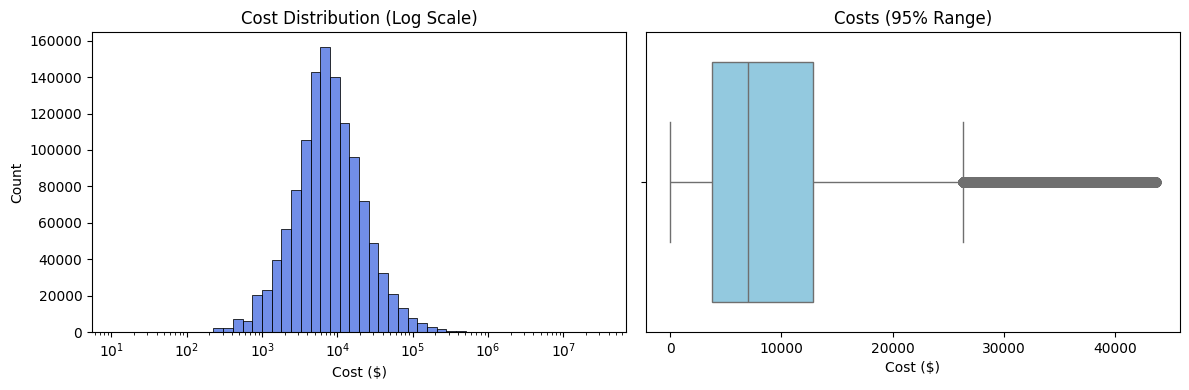

In [ ]:
# Inspect and visualize total cost ($)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Histogram
sns.histplot(nyc_subset_df.total_costs, bins=50, log_scale=True, ax=ax1, color="royalblue")
ax1.set_title("Cost Distribution (Log Scale)")
ax1.set_xlabel("Cost ($)")

# Boxplot
sns.boxplot(data=nyc_subset_df[nyc_subset_df.total_costs <= nyc_subset_df.total_costs.quantile(0.95)],
            x="total_costs",
            ax=ax2,
            color='skyblue')
ax2.set_title("Costs (95% Range)")
ax2.set_xlabel("Cost ($)")

plt.tight_layout()
plt.show()

In [20]:
# Change `length_of_stay` feature to numeric data type 
nyc_subset_df.length_of_stay = pd.to_numeric(nyc_subset_df.length_of_stay, errors="coerce")

nyc_subset_df.dtypes

health_service_area                     object
age_group                               object
gender                                  object
race                                    object
ethnicity                               object
length_of_stay                         float64
type_of_admission                       object
patient_disposition                     object
discharge_year                           int64
ccs_diagnosis_code                       int64
ccs_diagnosis_description               object
apr_severity_of_illness_code             int64
apr_severity_of_illness_description     object
total_costs                            float64
dtype: object

In [ ]:
# Inspect missing values after changing `lenght_of_stay` data type
nyc_subset_df.isnull().sum()

health_service_area                       0
age_group                                 0
gender                                    0
race                                      0
ethnicity                                 0
length_of_stay                         1260
type_of_admission                         0
patient_disposition                       0
discharge_year                            0
ccs_diagnosis_code                        0
ccs_diagnosis_description                 0
apr_severity_of_illness_code              0
apr_severity_of_illness_description       0
total_costs                               0
dtype: int64

In [32]:
# Handle missing values
nyc_subset_df = nyc_subset_df.dropna(subset=["length_of_stay"])

# Summary statistics of `length_of_stay`
nyc_subset_df.length_of_stay.describe().T

count    1.196474e+06
mean     5.442400e+00
std      8.009779e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.190000e+02
Name: length_of_stay, dtype: float64

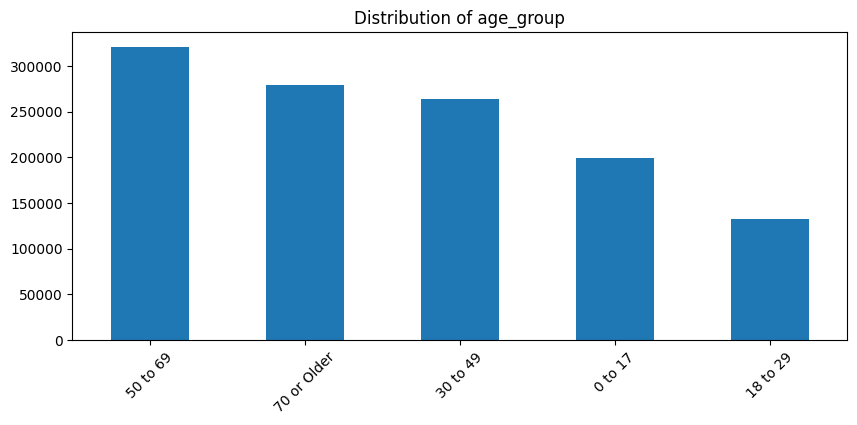

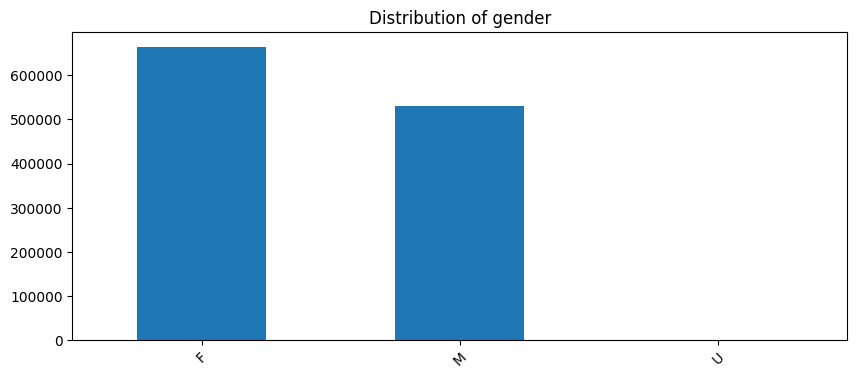

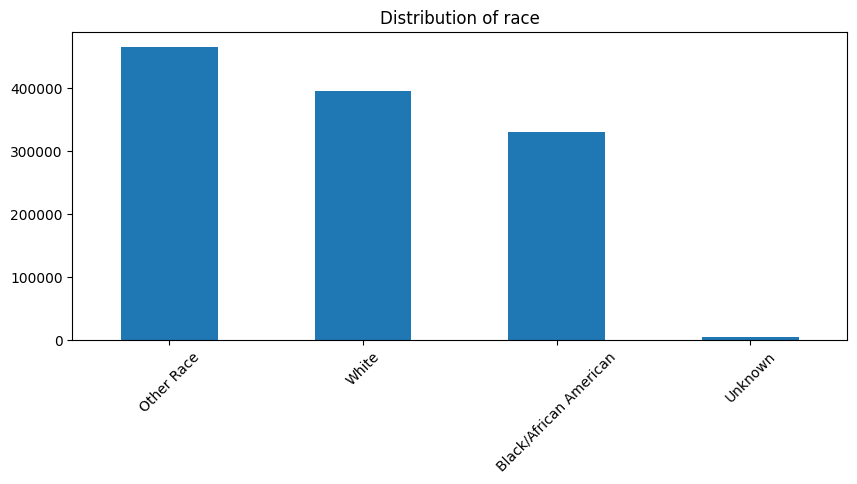

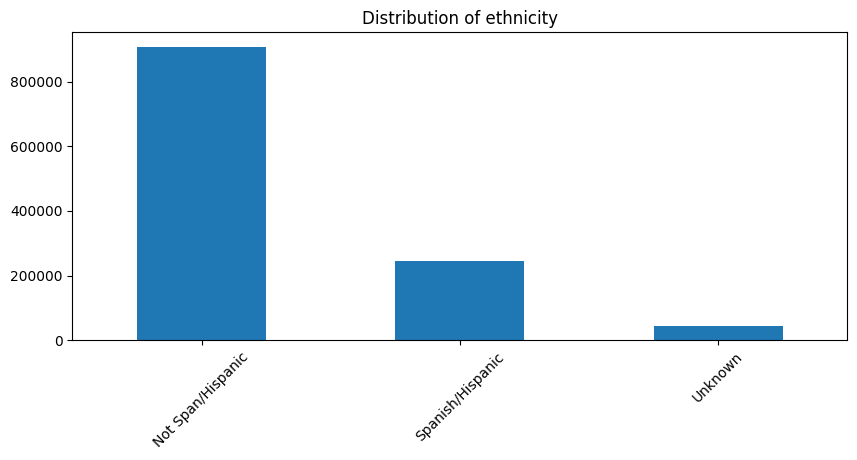

In [74]:
# Inspect and visualize demographics characteristics
demographic_features = ["age_group", "gender", "race", "ethnicity"]

for feature in demographic_features:
    plt.figure(figsize=(10, 4))
    nyc_subset_df[feature].value_counts().plot(kind="bar")
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.show()

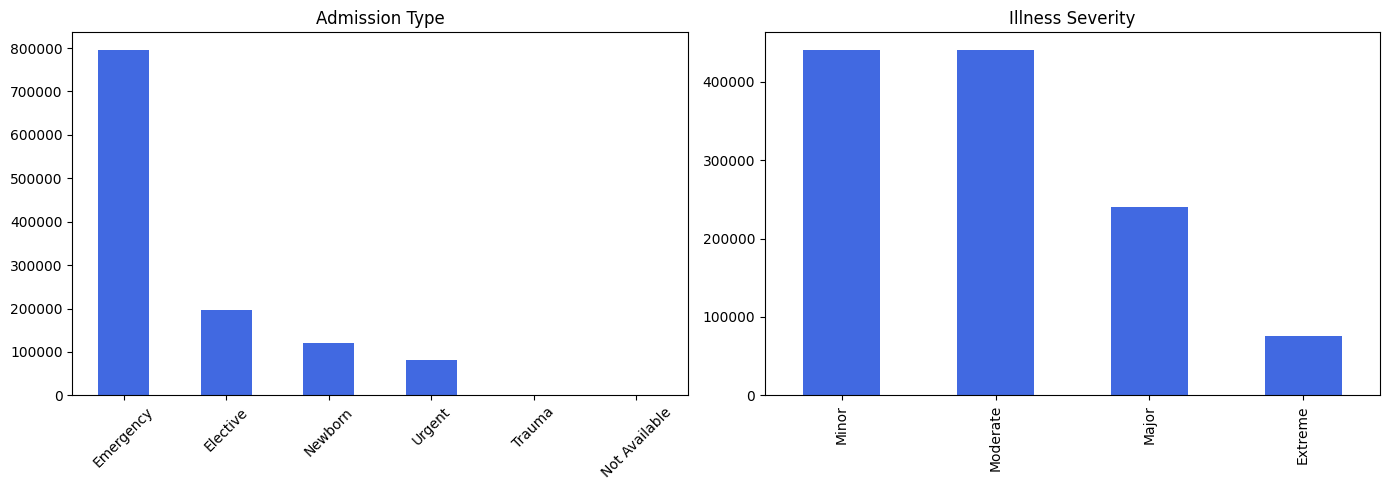

In [ ]:
# Inspect and visualize type of admission and severity of illness 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Admission Type
nyc_subset_df.type_of_admission.value_counts().plot(kind="bar", ax=ax1, color="royalblue")
ax1.set_title("Admission Type")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel("")

# Severity of Illness
severity_order = ["Minor", "Moderate", "Major", "Extreme"]
nyc_subset_df.apr_severity_of_illness_description.value_counts().loc[severity_order].plot(
    kind="bar", ax=ax2, color="royalblue")
ax2.set_title("Illness Severity")
ax2.set_xlabel("")

plt.tight_layout()
plt.show()

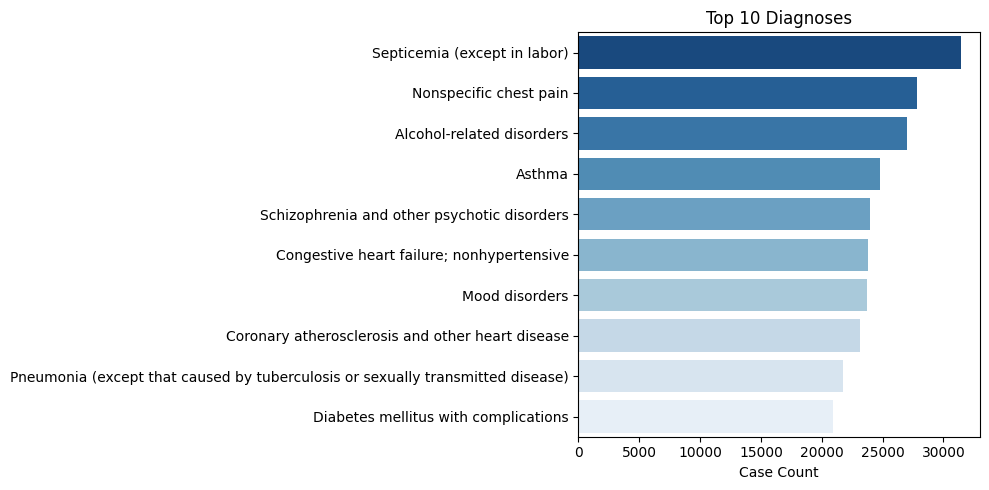

In [ ]:
# Visualize and inspect top diagnosis by case count, excluding obstetrics conditions 

# Exclude obstetrics related conditions 
exclude_terms = ["Liveborn", "Other complications of birth; puerperium affecting management of mother"]

# Top Diagnoses, excluding obstretics related diagnoses 

top_diagnoses = nyc_subset_df.ccs_diagnosis_description.value_counts().head(12)
top_diagnoses = top_diagnoses[~top_diagnoses.index.isin(exclude_terms)]

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x=top_diagnoses.values,
    y=top_diagnoses.index,
    hue=top_diagnoses.index,
    palette="Blues_r",
    legend=False
    )
plt.title("Top 10 Diagnoses")
plt.xlabel("Case Count")
plt.ylabel("")

plt.tight_layout()
plt.show()

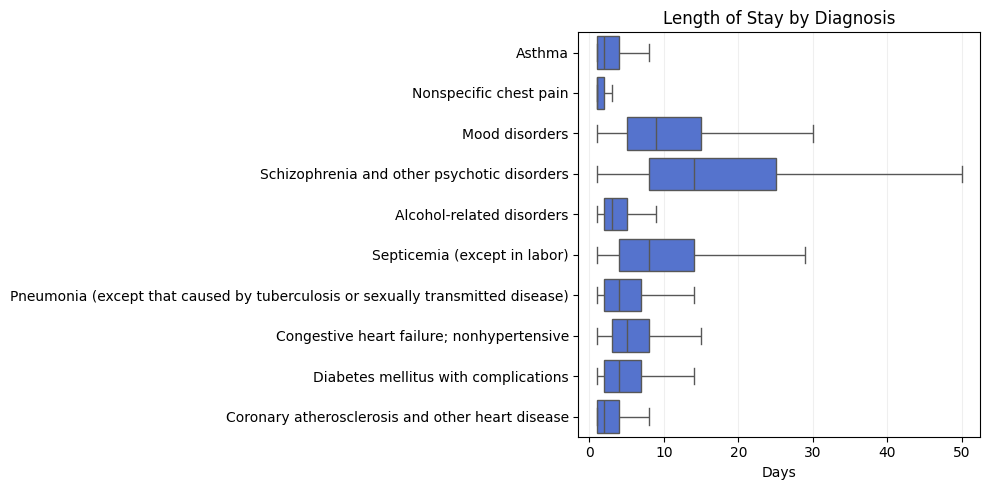

In [60]:
# Top 10 diagnosis and their respective length of stay
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=nyc_subset_df[nyc_subset_df.ccs_diagnosis_description.isin(top_diagnoses.index)],
    y="ccs_diagnosis_description",
    x="length_of_stay",
    showfliers=False,
    color="royalblue"
)
plt.title("Length of Stay by Diagnosis")
plt.xlabel("Days")
plt.ylabel("")
plt.grid(axis="x", alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
# Most common diagnoses and their respective length of stay, cost, and severity 
# Aggregate stats for top 10 diagnoses
top_diag_stats = nyc_subset_df[nyc_subset_df.ccs_diagnosis_description.isin(top_diagnoses.index)].groupby("ccs_diagnosis_description").agg(
    case_count=("length_of_stay", "count"),
    median_los=("length_of_stay", "median"),
    median_cost=("total_costs", "median"),
    predominant_severity=("apr_severity_of_illness_description", lambda x: x.mode()[0])
).sort_values("case_count", ascending=False).head(10)


top_diag_stats.style \
    .format({"median_cost": "${:,.0f}", "median_los": "{:.1f} days"}) \
    .background_gradient(subset=["case_count"], cmap="Blues") \
    .background_gradient(subset=["median_cost"], cmap="Reds") \
    .set_caption("<b>Top 10 Diagnoses: Volume, LOS, Cost & Severity</b>")

,case_count,median_los,median_cost,predominant_severity
ccs_diagnosis_description,,,,
Septicemia (except in labor),31431,8.0 days,"$17,156",Extreme
Nonspecific chest pain,27825,1.0 days,"$4,240",Minor
Alcohol-related disorders,27041,3.0 days,"$4,804",Moderate
Asthma,24749,2.0 days,"$5,374",Minor
Schizophrenia and other psychotic disorders,23940,14.0 days,"$16,506",Moderate
Congestive heart failure; nonhypertensive,23784,5.0 days,"$9,976",Major
Mood disorders,23691,9.0 days,"$10,801",Moderate
Coronary atherosclerosis and other heart disease,23141,2.0 days,"$11,307",Moderate
Pneumonia (except that caused by tuberculosis or sexually transmitted disease),21750,4.0 days,"$7,686",Moderate
